# Models

In [1]:
from text_analysis import lowercase_text_fields, remove_named_entities, pos_tagging, tokenize_regex, remove_stopwords, emotion_analysis, remove_punctuation, analyze_text_errors, analyze_readability
import pandas as pd 


df = pd.read_json("without_assessment_updated.jsonl", lines=True)
articles = df["Text"].to_list()
titles = df["Title"].to_list()
data = df[["Title", "Text"]].to_dict(orient="records")

features = []
data_lowercase = lowercase_text_fields(data)

for article in data_lowercase:
    title = article["Title"]
    text = article["Text"]

    pos_feats = pos_tagging(text)

    text_wo_punct = remove_punctuation(text)
    tokens = tokenize_regex(text_wo_punct)
    tokens_wo_sw = remove_stopwords(tokens)
    clean_text = " ".join(tokens_wo_sw)
    emotion_feats = emotion_analysis(clean_text)

    ner_cleaned_text = remove_named_entities(text)
    spell_err = analyze_text_errors(ner_cleaned_text)

    reading_feats = analyze_readability(text)

    row = {
        "Title": title,
        "noun_pct": pos_feats[0],
        "verb_pct": pos_feats[1],
        "adj_pct": pos_feats[2],
        "adv_pct": pos_feats[3],
        "pron_pct": pos_feats[4],
        "adj_noun_ratio": pos_feats[5],
        "adv_verb_ratio": pos_feats[6],
        "spelling_error_rate": spell_err,
        #"reading_ease": reading_feats[0],
        #"kincaid_grade": reading_feats[1],
        "gunning_fog": reading_feats[2],
        #"smog": reading_feats[3],
        "automated_readability": reading_feats[4]
    }

    emotions = ['anger', 'fear', 'disgust', 'sadness', 'joy', 'surprise', 'trust', 'anticipation', 'positive', 'negative']
    for i, emotion in enumerate(emotions):
        row[f"emotion_{emotion}"] = emotion_feats[i]

    features.append(row)

features_df = pd.DataFrame(features)
labels_df = pd.read_csv("group31_stage1.csv", sep=";")
labels_df["label"] = labels_df["real_news"].replace({"yes": 1, "no": 0})
adjusted_index = labels_df["index"] - 1
features_df.loc[adjusted_index, "Label"] = labels_df["label"].values
print(features_df.head)

[nltk_data] Downloading package punkt_tab to /Users/ida/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ida/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ida/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<bound method NDFrame.head of                                                  Title  noun_pct  verb_pct  \
0    is it clouds, shipping or a volcano? scientist...     0.248     0.129   
1    world's forests failed to curb 2023 climate em...     0.289     0.125   
2    alarmists threaten ‘worldwide societal breakdo...     0.291     0.114   
3    corporate media relying on very recent history...     0.256     0.119   
4    media, stop blaming 'climate change' for hurri...     0.264     0.125   
..                                                 ...       ...       ...   
145  federal scientist cooked climate change books ...     0.242     0.139   
146  china's glacier area shrinks by 26% over six d...     0.256     0.110   
147  manmade climate change based on ‘imagination &...     0.299     0.094   
148           why climate change is good for the world     0.265     0.109   
149  pope francis says alcoholics, autistic and dis...     0.249     0.132   

     adj_pct  adv_pct  pron_pct  

/var/folders/nx/3dtsq4dd3bj446q4qgr8b1gh0000gn/T/ipykernel_37915/1151876664.py:55: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df["label"] = labels_df["real_news"].replace({"yes": 1, "no": 0})


In [2]:
from sklearn.model_selection import train_test_split

X = features_df.drop('Label', axis=1)
X = X.drop('Title', axis=1)
y = features_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def evaluation(model, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = model.predict(X_train)
        y_true = y_train
        dataset_type = "Training"
    else:
        pred = model.predict(X_test)
        y_true = y_test
        dataset_type = "Test"

    acc = accuracy_score(y_true, pred)
    prec = precision_score(y_true, pred)
    rec = recall_score(y_true, pred)
    f1 = f1_score(y_true, pred)

    print(f"{dataset_type} Result:\n" + "="*50)
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision      : {prec:.4f}")
    print(f"Recall         : {rec:.4f}")
    print(f"F1 Score       : {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, pred))

    cm = confusion_matrix(y_true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{dataset_type} Confusion Matrix")
    plt.grid(False)
    plt.show()

## Random Forest

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=15, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=20, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=20, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=15, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=15, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=15, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=20, n_estimators

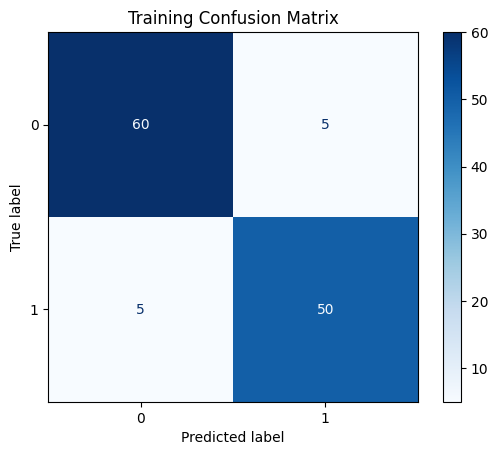

Test Result:
Accuracy       : 0.7000
Precision      : 0.6667
Recall         : 0.5000
F1 Score       : 0.5714

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.83      0.77        18
         1.0       0.67      0.50      0.57        12

    accuracy                           0.70        30
   macro avg       0.69      0.67      0.67        30
weighted avg       0.70      0.70      0.69        30



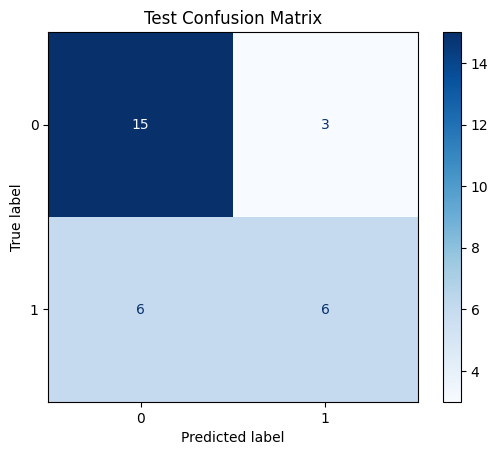

Test Result:
Accuracy       : 0.8733
Precision      : 0.8750
Recall         : 0.8358
F1 Score       : 0.8550

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89        83
         1.0       0.88      0.84      0.85        67

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150



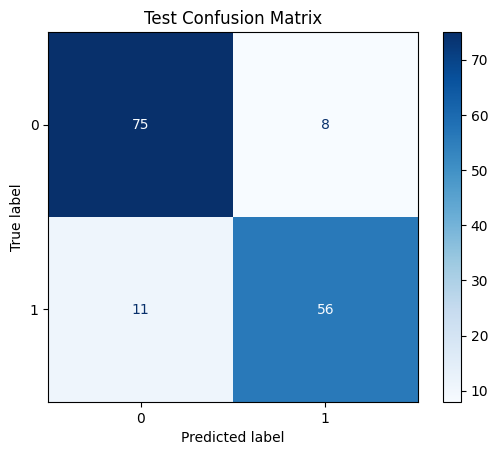

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_distributions = {
    'n_estimators': [200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 8, 10],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [5, 8, 6, 10],
    'bootstrap': [True]
}


random_forest_model = RandomForestClassifier(random_state=0)

random_search = RandomizedSearchCV(estimator=random_forest_model,
                                   param_distributions=param_distributions,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Parameters found: ", best_params)

best_model = random_search.best_estimator_
evaluation(best_model, X_train, y_train, X_test, y_test, train=True)
evaluation(best_model, X_train, y_train, X_test, y_test, train=False)
evaluation(best_model, X_train, y_train, X, y, train=False) # whole set


results to csv

In [5]:
predictions = best_model.predict(X)

label_map = {1: "yes", 0: "no"}
predicted_labels = [label_map[pred] for pred in predictions]

submission_df = pd.DataFrame({
    'index': range(1, len(predicted_labels) + 1),
    'real_news': predicted_labels
})

#submission_df.to_csv("predictions.csv", index=False)


## Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

log_reg = LogisticRegression(
    random_state=42,
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced'
)

param_distributions = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_log_reg = random_search.best_estimator_

def evaluation(model, X_train, y_train, X_test, y_test, X, y):
    for split, X, y in [('Train', X_train, y_train), ('Test', X_test, y_test), ('All', X, y)]:
        y_pred = model.predict(X)
        print(f"{split} Results:")
        print("="*40)
        print(f"Accuracy : {accuracy_score(y, y_pred):.4f}")
        print(f"Precision: {precision_score(y, y_pred):.4f}")
        print(f"Recall   : {recall_score(y, y_pred):.4f}")
        print(f"F1 Score : {f1_score(y, y_pred):.4f}")
        print()

evaluation(best_log_reg, X_train, y_train, X_test, y_test, X, y)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1

with scaling

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000, class_weight='balanced'))
])

param_distributions = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100],
    'log_reg__penalty': ['l1', 'l2']
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_pipeline = random_search.best_estimator_
evaluation(best_pipeline, X_train, y_train, X_test, y_test, X, y)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...............log_reg__C=0.01, log_reg__penalty=l1; total time=   0.0s
[CV] END ...............log_reg__C=0.01, log_reg__penalty=l1; total time=   0.0s
[CV] END ...............log_reg__C=0.01, log_reg__penalty=l1; total time=   0.0s
[CV] END ...............log_reg__C=0.01, log_reg__penalty=l2; total time=   0.0s
[CV] END ...............log_reg__C=0.01, log_reg__penalty=l2; total time=   0.0s
[CV] END ................log_reg__C=0.1, log_reg__penalty=l1; total time=   0.0s
[CV] END ................log_reg__C=0.1, log_reg__penalty=l1; total time=   0.0s
[CV] END ................log_reg__C=0.1, log_reg__penalty=l2; total time=   0.0s
[CV] END ................log_reg__C=0.1, log_reg__penalty=l1; total time=   0.0s
[CV] END ...............log_reg__C=0.01, log_reg__penalty=l2; total time=   0.0s
[CV] END ................log_reg__C=0.1, log_reg__penalty=l2; total time=   0.0s
[CV] END ................log_reg__C=0.1, log_reg